In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback, TqdmCallback
from deephyper.problem import HpProblem
from deephyper.search.hps import CBO
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from torch.nn import CrossEntropyLoss
from torchvision.ops import sigmoid_focal_loss
from tqdm import tqdm

from psd_gnn.dataset import PSD_Dataset
from psd_gnn.models.node_classifier import GNN
from psd_gnn.utils import eval_metrics, parse_adj
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
torch.manual_seed(0)
np.random.seed(0)
''' Load data '''
dataset = PSD_Dataset("../",
                      "1000genome",
                      force_reprocess=True, 
                      node_level=True,
                      binary_labels=True, 
                      )
data = dataset[0]
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
n_nodes = data.num_nodes

NUM_NODE_FEATURES = dataset.num_node_features
NUM_OUT_FEATURES = dataset.num_classes


Processing...
/home/jinh/PoSeiDon/graph_nn_2/psd_gnn/dataset.py:202: RuntimeWarning: invalid value encountered in divide
  norm_feat = (all_feat - v_min) / (v_max - v_min)
Done!


In [4]:
''' train model '''
model = GNN(NUM_NODE_FEATURES,
            64,
            NUM_OUT_FEATURES,
            n_conv_blocks=2,
            dropout=0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=0)
data = dataset[0]
data = data.to(DEVICE)
model.train()
class_weight = 1 - data.y[data.train_mask].bincount() / data.y[data.train_mask].shape[0]
for epoch in range(500):
    optimizer.zero_grad()
    y_hat = model(data.x, data.edge_index)
    train_loss = CrossEntropyLoss(weight=class_weight)(y_hat[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()
    
model.eval()
val_y_true = data.y[data.val_mask].detach().cpu().numpy()
val_y_pred = y_hat[data.val_mask].argmax(dim=1).detach().cpu().numpy()
val_acc = accuracy_score(val_y_true, val_y_pred)
val_f1 = f1_score(val_y_true, val_y_pred)
val_roc_auc = roc_auc_score(val_y_true, val_y_pred)


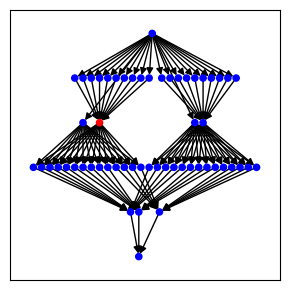

In [5]:
nodes, edges = parse_adj("1000genome")
G = nx.DiGraph(edges)
# n_id = 23
# n_subset = {23}
# for edge in edges:
#     print(edge)
#     if n_id in edge:
#         n_subset.add(edge[0])
#         n_subset.add(edge[1])
# n_subset = list(n_subset)
# subgraph = nx.subgraph(G, n_subset)
fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)

pos = graphviz_layout(G, prog="dot")
c = ['b'] * len(G.nodes)
c[list(G.nodes).index(23)] = 'r'
nx.draw_networkx(G, pos, node_size=20, node_color=c, cmap=plt.cm.bwr, with_labels=False)
plt.savefig("exp_G_node_23.pdf")

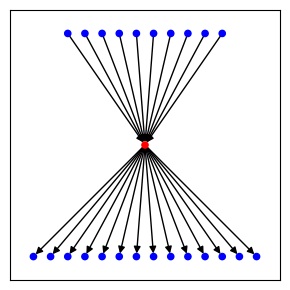

In [6]:
n_id = 23
n_subset = {23}
for edge in edges:
    # print(edge)
    if n_id in edge:
        n_subset.add(edge[0])
        n_subset.add(edge[1])
n_subset = list(n_subset)
subgraph = nx.subgraph(G, n_subset)
fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)

pos = graphviz_layout(subgraph, prog="dot")
c = ['b'] * len(subgraph.nodes)
c[list(subgraph.nodes).index(23)] = 'r'
nx.draw_networkx(subgraph, pos, node_size=20, node_color=c, cmap=plt.cm.bwr, with_labels=False)
plt.savefig("exp_subG_node_23.pdf")

In [7]:
''' GNN Explainer '''
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer

# data = Data(...)  # A homogenous graph data object.

# explainer = Explainer(
#     model=model,
#     algorithm=GNNExplainer(epochs=200),
#     explanation_type='model',
#     node_mask_type='attributes',
#     edge_mask_type='object',
#     model_config=dict(
#         mode='multiclass_classification',
#         task_level='node',
#         return_type='log_probs',  # Model returns log of probability.
#     ),
# )

# # Generate explanation for the node at index `10`:
# explanation = explainer(data.x, data.edge_index, index=10)
# print(explanation.edge_mask)
# print(explanation.node_mask)

# explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
# node_idx = 10
# node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index,
#                                                    edge_weight=data.edge_weight)
# ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y)
# plt.show()

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explainer_config=dict(
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type=None,
    ),
    model_config=dict(
        mode='classification',
        task_level='graph',
        return_type='log_probs',
    ),
)
node_index = 23
explanation = explainer(data.x,
                        data.edge_index,
                        index=node_index,
                        edge_weight=data.edge_weight)
print(f'Generated explanations in {explanation.available_explanations}')


Generated explanations in ['node_feat_mask']


In [8]:
explanation.node_feat_mask.reshape(-1, 57, NUM_NODE_FEATURES)

tensor([[[0.2959, 0.1742, 0.1505,  ..., 0.6818, 0.1452, 0.1411],
         [0.1592, 0.3705, 0.1590,  ..., 0.4217, 0.1401, 0.1407],
         [0.1583, 0.1702, 0.1605,  ..., 0.1413, 0.1544, 0.1573],
         ...,
         [0.1561, 0.1587, 0.1667,  ..., 0.1517, 0.1516, 0.1491],
         [0.1456, 0.1551, 0.1212,  ..., 0.1373, 0.1419, 0.1551],
         [0.1502, 0.1599, 0.1609,  ..., 0.1670, 0.1563, 0.1672]],

        [[0.1561, 0.1736, 0.1553,  ..., 0.1441, 0.1427, 0.1695],
         [0.1555, 0.1536, 0.1475,  ..., 0.1556, 0.1552, 0.1606],
         [0.1519, 0.1385, 0.1437,  ..., 0.1486, 0.1697, 0.1589],
         ...,
         [0.1466, 0.1706, 0.1472,  ..., 0.1584, 0.1538, 0.1430],
         [0.1580, 0.1558, 0.1540,  ..., 0.1402, 0.1567, 0.1528],
         [0.1736, 0.1515, 0.1685,  ..., 0.1533, 0.1419, 0.1596]],

        [[0.1435, 0.1771, 0.1539,  ..., 0.1492, 0.1596, 0.1740],
         [0.1560, 0.1610, 0.1423,  ..., 0.1489, 0.1526, 0.1705],
         [0.1570, 0.1516, 0.1695,  ..., 0.1633, 0.1601, 0.

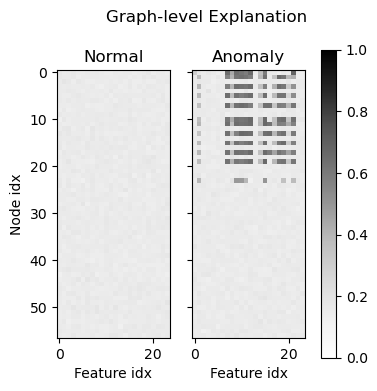

In [14]:
from matplotlib import colors
fig, axs = plt.subplots(1,2, figsize=(4,4))
fig.suptitle("Graph-level Explanation")
# Normal
d0 = explanation.node_feat_mask.reshape(-1, 57, NUM_NODE_FEATURES)[-1].cpu().numpy()
# Anomaly
d1 = explanation.node_feat_mask.reshape(-1, 57, NUM_NODE_FEATURES)[0].cpu().numpy()

images = []
images.append(axs[0].imshow(d0, cmap="Greys"))
images.append(axs[1].imshow(d1, cmap="Greys"))
axs[0].label_outer()
axs[1].label_outer()
axs[0].set_title("Normal")
axs[1].set_title("Anomaly")
axs[0].set_ylabel("Node idx")
axs[0].set_xlabel("Feature idx")
axs[1].set_xlabel("Feature idx")

# for i in range(1):
#     for j in range(2):
#         # Generate data with a range that varies from one plot to the next.
#         # data = ((1 + i + j) / 10) * np.random.rand(10, 20)
#         images.append(axs[i, j].imshow(data))
#         axs[i, j].label_outer()

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=0, vmax=1)
for im in images:
    im.set_norm(norm)

# fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.05)
fig.colorbar(images[1], ax=axs)


# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())

for im in images:
    im.callbacks.connect('changed', update)

plt.savefig("exp_graph.pdf")

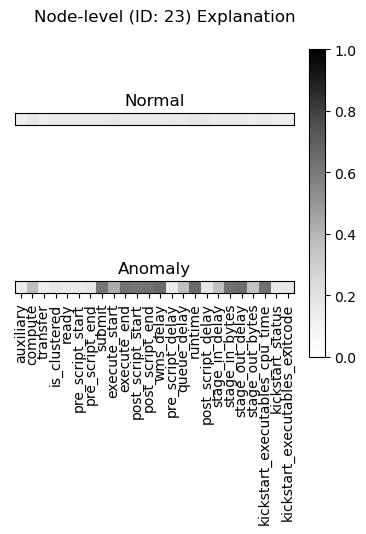

In [91]:
features = ['auxiliary', 'compute', 'transfer'] + \
    ['is_clustered', 'ready', 'pre_script_start',
     'pre_script_end', 'submit', 'execute_start', 'execute_end',
     'post_script_start', 'post_script_end', 'wms_delay', 'pre_script_delay',
     'queue_delay', 'runtime', 'post_script_delay', 'stage_in_delay',
     'stage_in_bytes', 'stage_out_delay', 'stage_out_bytes', 'kickstart_executables_cpu_time',
     'kickstart_status', 'kickstart_executables_exitcode']
from matplotlib import colors
fig, axs = plt.subplots(2,1, figsize=(4,4))
fig.suptitle("Node-level (ID: 23) Explanation")
images = []
images.append(axs[0].imshow(d0[10:11, :], cmap="Greys"))
images.append(axs[1].imshow(d1[10:11, :], cmap="Greys"))
axs[0].label_outer()
axs[1].label_outer()
axs[0].set_title("Normal")
axs[1].set_title("Anomaly")

axs[0].set_xticks([])
axs[1].set_xticks(np.arange(24), labels=features, rotation=90)
axs[0].set_yticks([])
axs[1].set_yticks([])
# axs[1].set_xticks
# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=0, vmax=1)
for im in images:
    im.set_norm(norm)

# fig.colorbar(images[1], ax=axs, orientation='horizontal', fraction=.05)
# divider = make_axes_locatable(axs[1])
# cax = divider.append_axes("bottom", "5%", pad="3%")
# fig.colorbar(images[1], ax=axs, cax=cax, orientation='horizontal')
# fig.colorbar(images[1], ax=axs.ravel().tolist(), orientation='horizontal')

# divider = make_axes_locatable(axs[0])
# cax = divider.new_vertical(size = '80%', pad = 0.5)
# fig.add_axes(cax)
# fig.colorbar(images[1], cax = cax, orientation = 'horizontal')

# plt.colorbar(images[1], ax=axs[0], fraction=0.046)
plt.colorbar(images[1], ax=axs, fraction=0.05)


# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())

for im in images:
    im.callbacks.connect('changed', update)
# plt.tight_layout()
# plt.subplots_adjust(left=0.2, right=0.75, bottom=0.3, top=0.9)
plt.savefig("exp_node.pdf", bbox_inches="tight")
# # Normal
# d0 = explanation.node_feat_mask.reshape(-1, 57, NUM_NODE_FEATURES)[-1].cpu().numpy()
# # Anomaly
# d1 = explanation.node_feat_mask.reshape(-1, 57, NUM_NODE_FEATURES)[0].cpu().numpy()

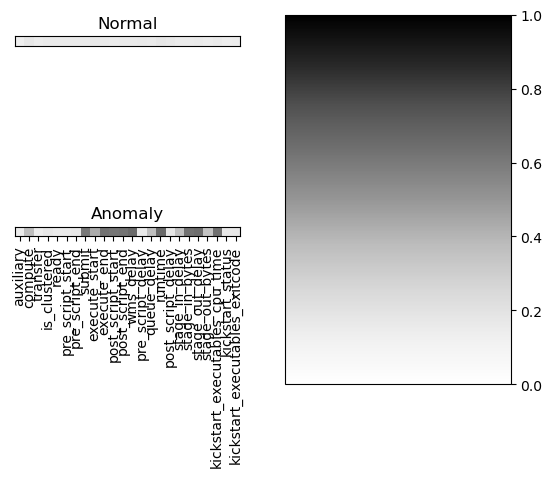

In [59]:
images = []
ax1 = plt.subplot2grid((6, 2), (0, 0), rowspan=1)
images.append(ax1.imshow(d0[10:11, :], cmap="Greys"))

ax2 = plt.subplot2grid((6, 2), (1, 0), rowspan=5)
images.append(ax2.imshow(d1[10:11, :], cmap="Greys"))
ax3 = plt.subplot2grid((6, 2), (0, 1), rowspan=6)
ax1.label_outer()
ax2.label_outer()
ax1.set_title("Normal")
ax2.set_title("Anomaly")
# ax1.set_ylabel("Node 10")
# ax1.set_xlabel("Feature idx")
# ax2.set_xlabel("Feature idx")
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])
ax2.set_xticks(np.arange(24), labels=features, rotation=90)
# ax2.set_xticks
# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=0, vmax=1)
for im in images:
    im.set_norm(norm)

# fig.colorbar(images[1], ax=axs, orientation='horizontal', fraction=.05)
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("bottom", "5%", pad="3%")
# fig.colorbar(images[1], ax=axs, cax=cax, orientation='horizontal')
# fig.colorbar(images[1], ax=axs.ravel().tolist(), orientation='horizontal')

# divider = make_axes_locatable(ax1)
# cax = divider.new_vertical(size = '80%', pad = 0.5)
# fig.add_axes(cax)
# fig.colorbar(images[1], cax = cax, orientation = 'horizontal')

plt.colorbar(images[1], cax=ax3, fraction=0.05)


# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())

for im in images:
    im.callbacks.connect('changed', update)
